## Calculation of polarons hopping barriers and mobilities

Author: Z. Dai (v1, 09/05/2024) <br>
Revision: 

In this notebook, we perform calculations of polaron mobilities from hoppings. The underlying method is the Emin-Holstein-Austin-Mott theory, and the computational workflow is presented in [PNAS, **121**, e2318151121 (2024)](https://www.pnas.org/doi/10.1073/pnas.2318151121).

Electrons and phonons are computed with Quantum ESPRESSO (QE), maximally-localized Wannier functions are computed with Wannier90, and polarons are computed with EPW. 

### Set up working environment

Load required modules:

In [38]:
%matplotlib inline

import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MultipleLocator,FormatStrFormatter
import os
import pandas as pd
#
import sys
print(str(os.getcwd()))
sys.path.insert(0,str(os.getcwd())+'/../')
from EPWpy import EPWpy
from EPWpy.plotting import plot_polaron
# from EPWpy.utilities import EPW_util

/home1/09084/zhenbang


Set paths to relevant directories:

In [ ]:
# Set QE binaries directory
QE = '/scratch/tacc/apps/intel19/impi19_0/qe/7.3/bin'
prefix='lif'


Set the number of cores to be used in the calculations:

In [ ]:
# Maximum number of cores to be used
cores = 128
print('Maximum number of cores to be used:', cores)

Define general calculation parameters to be used throughout the workflow:

In [ ]:
lif=EPWpy.EPWpy({'prefix':prefix,
           'restart_mode':'\'from_scratch\'',
           'calculation':'\'scf\'',
           'ibrav':2,
           'nat':2,
           'ntyp':2,
           'atomic_species':['Li', 'F'],
           'atomic_pos':np.array([[0.0, 0.0, 0.0], [-0.5, 0.5, 0.5]]), # in alat
           'mass':[6.941, 18.9984],
           'atoms':['Li', 'F'],
           'ecutwfc':'80',
           'celldm(1)':'7.67034',
           'verbosity':'high',
           'pseudo_auto':True},
           code=QE,
           env='ibrun',
           system='lif')
lif.run_serial = True
lif.env = 'ibrun'
#'pseudo_dir':'\''+str(pseudo)+'\''},

# Print relevant info
os.system('module list')

### Workflow

We will consider a hole polaron in LiF as an example.

#### Preliminary scf, ph, and nscf calculations

In [8]:
# Prepare scf input file
lif.scf(electrons={'conv_thr':'1.0d-12'}, kpoints={'kpoints':[[6, 6, 6]]}, name='scf')
lif.prepare(4,type_run='scf')

# Run scf calculation
lif.run(128, parallelization=' -nk 32 -nd 4')

parallelization chosen:   -nk 32 -nd 4
-- -- -- -- -- -- -- -- -- -- --  Calculation: scf  -- -- -- -- -- -- -- -- -- -- -- 
Running scf |████████████████████████████████████████| in 6.8s (0.22/s)         

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [9]:
# Prepare ph input file
#lif.ph(phonons={'fildyn':'\'lif.dyn\'','nq1':6,'nq2':6,'nq3':6,'fildvscf':'\'dvscf\''})
lif.ph(phonons={'nq1':6,
                'nq2':6,
                'nq3':6})

# Run ph calculation
lif.prepare(20,type_run='ph')
lif.run(128,type_run='ph', parallelization=' -nk 32 -nd 4')

parallelization chosen:   -nk 32 -nd 4
-- -- -- -- -- -- -- -- -- -- --  Calculation: ph  -- -- -- -- -- -- -- -- -- -- -- 
Running ph |████████████████████████████████████████| in 10:37.5 (0.00/s)       |████████████████████                    | ▇▅▃ in 0s (~0s, 844.4/s)  

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [10]:
# Prepare nscf input file
lif.nscf(system={'nbnd':15},kpoints={'grid':[6, 6, 6],'kpoints_type': 'crystal'})
lif.prepare(20,type_run='nscf')

# Run nscf calculation
lif.run(128,type_run='nscf', parallelization=' -nk 32 -nd 4')

parallelization chosen:   -nk 32 -nd 4
-- -- -- -- -- -- -- -- -- -- --  Calculation: nscf  -- -- -- -- -- -- -- -- -- -- -- 
Running nscf |████████████████████████████████████████| in 10.0s (0.14/s)       █▆▄ in 0s (~0s, 1011.9/s

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


#### Coarse mesh epw calculations

In [13]:
# Prepare epw input for coarse mesh calculation
lif.reset()
lif.epw(epwin={'proj':['\'F : p\''],
               'elph':'.true.',
               'etf_mem':0,
               'epwwrite':'.true.',
               'epwread':'.false.',
               'wannier_plot':'.true.',
               'band_plot':'.true.',
               'filkf':'\'./path.kpt\'',
               'filqf':'\'./path.kpt\'',
               'num_iter':500,
               'epbwrite':'.false.',
               'nbndsub':'3',
               'bands_skipped':'\'exclude_bands = 1:2, 6:15\'',
               'wannier_plot':'.true.',
               'wannier_plot_supercell':'6, 6, 6',
               'lpolar':'.true.',
               'eig_read':'.false.',
              'wannierize':'.true.'},
        name='epw1')
# Generate filkf if needed

W=[0.5,0.75,0.25]
L=[0.0,0.5,0.0]
G=[0.0,0.0,0.0]
X=[0.5,0.5,0.0]
K=[0.375,0.75,0.375]
sympoints=[W,L,G,X,W,K]
#
lif.filkf(path=sympoints, length=[41, 41, 41, 41, 41], name='path.kpt')

#
lif.prepare(1,type_run='epw1') 


obtaining nscf and ph attributes
nscf ph
-- -- -- -- -- -- -- -- -- -- -- -- -- Info -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Based on previous pw and ph calculations some parameters are set below
lpolar:  .true. (related to epsil in ph)
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
(4, 3)
[51, 51, 51]


In [14]:
print(lif.code)

#lif.env='mpirun -np 4'
lif.run(128,type_run='epw1')

/scratch/tacc/apps/intel19/impi19_0/qe/7.3/bin
-- -- -- -- -- -- -- -- -- -- --  Calculation: epw1  -- -- -- -- -- -- -- -- -- -- -- 
Running epw1 |████████████████████████████████████████| in 1:46.4 (0.01/s)      

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


#### Interpolation to a relatively fine mesh and solution of polaron equations

In [17]:
# Prepare epw input for fine mesh interpolation and polaron calculation

lif.epw(epwin={'bands_skipped':'\'exclude_bands = 1:2, 6:15\'',
               'etf_mem':0,
               'nbndsub':3,
               'plrn':'.true.',
               'restart_plrn':'.false.',
               'type_plrn':1,
               'init_plrn':1,
               'init_sigma_plrn':1.0,
               'niter_plrn':500,
               'conv_thr_plrn':1.0E-4,
               'ethrdg_plrn':1.0E-6,
               'adapt_ethrdg_plrn':'.true.',
               'init_ethrdg_plrn':1.0E-4,
               'nethrdg_plrn':20,
               'io_lvl_plrn':0,
               'nkf1':6,
               'nkf2':6,
               'nkf3':6,
               'nqf1':6,
               'nqf2':6,
               'nqf3':6,
               'lpolar':'.true.',
               'eig_read':'.false.'},
            name='epw2')

#
lif.prepare(1,type_run='epw2')

-- -- -- -- -- -- -- -- -- -- -- -- -- Warning -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Refreshing EPW input (remove refresh from epw_save.json if not needed)
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- Info -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Based on previous pw and ph calculations some parameters are set below
lpolar:  .true. (related to epsil in ph)
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [18]:
# Run
lif.run(128,type_run='epw2')

-- -- -- -- -- -- -- -- -- -- --  Calculation: epw2  -- -- -- -- -- -- -- -- -- -- -- 
Running epw2 |████████████████████████████████████████| in 12.7s (0.11/s)       

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


#### From the displacement pattern, translate the polaron by one unit cell.

In [35]:
print(os.getcwd())
prefix=lif.prefix
print(prefix+'/epw/dtau.plrn')


"""
For reading dtau.plrn for further postprocessing
"""
file = open(prefix+'/epw/dtau.plrn', 'r');
control = ( file.readline() ).split();
control = np.array(control, dtype=int);

dim = [control[0], control[1], control[2]]
dim.append(control[-1] // 3)
dim.append(3)

disp = np.zeros((dim),dtype=complex);

for ix in range(control[0]):
    for iy in range(control[1]):
        for iz in range(control[2]):
            for iat in range(dim[-2]):
                for icart in range(3):
                    temp = ( file.readline() ).split()
                    disp[ix,iy,iz,iat,icart] = float(temp[-2]) + 1j * float(temp[-1])


file.close();


"""
Shift the polaron along the [100] direction
"""
shift_x = np.zeros((np.shape(disp)),dtype=complex);

params = np.shape(disp)

idx = np.zeros((params[0]), dtype=int)
idx[0:params[0] - 1] = np.arange(1, params[0], dtype=int); idx[-1] = 0

for ix in range(params[0]):
    for iy in range(params[1]):
        for iz in range(params[2]):
            for iat in range(params[3]):
                for icart in range(3):
                    shift_x[idx[ix], iy, iz, iat, icart] = disp[ix, iy, iz, iat, icart]

"""
Generate the dtau_disp.plrn_* files
"""
midpoints = 21;
scaling = np.linspace(0,1,21,endpoint=True)
shift = shift_x - disp

for i in range(midpoints):
    file = open(prefix + '/epw/dtau_disp.plrn_' + str(i+1), 'w');

    file.write( '{:10d}'.format(params[0]) + '{:10d}'.format(params[1]) + '{:10d}'.format(params[2]) );
    file.write( '{:10d}'.format(params[0] * params[1] * params[2]) );
    file.write( '{:10d}'.format(params[3] * 3)  + '\n');


    for ix in range(params[0]):
        for iy in range(params[1]):
            for iz in range(params[2]):
                iunit = ix * params[1] * params[2] + iy * params[2] + iz + 1
                for iat in range(params[3]):
                    for icart in range(3):
                        ifree = iat * 3 + icart + 1
                        disp_value = shift[ix, iy, iz, iat, icart] * scaling[i]+\
                                      disp[ix, iy, iz, iat, icart];
                        
                        file.write( '{:18.10E}'.format(np.real(disp_value)) + '{:18.10E}'.format(np.imag(disp_value)) +'\n' )


    file.close();

/home1/09084/zhenbang
lif/epw/dtau.plrn


#### Perform the polaron calculations with given atomic displacements, and compute the polaron total energy for each given displacements

In [51]:
lif.epw(epwin={'etf_mem':0,
               'bands_skipped':'\'exclude_bands = 1:2, 6:15\'',
               'nbndsub':3,
               'plrn':'.true.',
               'restart_plrn':'.false.',
               'type_plrn':1,
               'init_plrn':6,
               'init_ntau_plrn':str(midpoints),
               'init_sigma_plrn':1.0,
               'niter_plrn':1,
               'conv_thr_plrn':1.0E-4,
               'ethrdg_plrn':1.0E-6,
               'adapt_ethrdg_plrn':'.true.',
               'init_ethrdg_plrn':1.0E-4,
               'nethrdg_plrn':20,
               'io_lvl_plrn':0,
               'nkf1':6,
               'nkf2':6,
               'nkf3':6,
               'nqf1':6,
               'nqf2':6,
               'nqf3':6,
               'lpolar':'.true.',
               'eig_read':'.false.'},
            name='epw2.dtau')

#
lif.prepare(1,type_run='epw2',name = 'epw',infile='epw2.dtau.in')

lif.run(128,type_run='epw2', infile='epw2.dtau')

-- -- -- -- -- -- -- -- -- -- -- -- -- Warning -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Refreshing EPW input (remove refresh from epw_save.json if not needed)
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- -- -- -- Info -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Based on previous pw and ph calculations some parameters are set below
lpolar:  .true. (related to epsil in ph)
-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
-- -- -- -- -- -- -- -- -- -- --  Calculation: epw2.dtau  -- -- -- -- -- -- -- -- -- -- -- 
Running epw2.dtau |████████████████████████████████████████| in 13.1s (0.11/s)  

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


#### Plot the potential surface and extract the hopping barrier

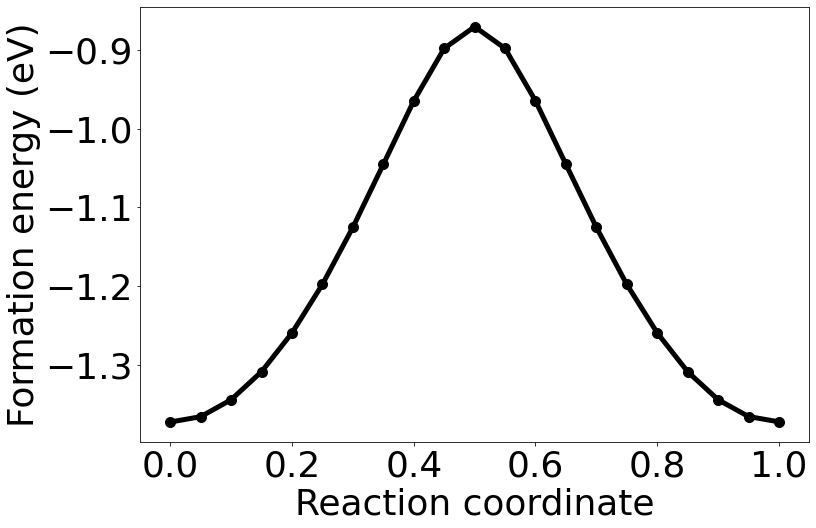

Hopping barrier (eV):  0.5021256


In [52]:
prefix=lif.prefix
E_pot_surf = []
file = open(prefix + '/epw/epw2.dtau.out', 'r')
for line in file:
    if "Formation Energy at this " in line:
        E_pot_surf.append( float(line.split()[-1]) )
file.close()

font = {'family' : 'DejaVu Sans',
    'size'   : 36}
plt.rc('font', **font)

fig, ax = plt.subplots(1, figsize=(12,8))
ax.plot(scaling, E_pot_surf, marker='o', markersize=10, linewidth=5, color='black')
ax.set_xlabel('Reaction coordinate')
ax.set_ylabel('Formation energy (eV)')

plt.show()

plt.close()

E_barrier = max(E_pot_surf) - min(E_pot_surf)

print('Hopping barrier (eV): ', E_barrier)

#### Compute the mobility from the Emin-Holstein-Austin-Mott (EHAM) theory

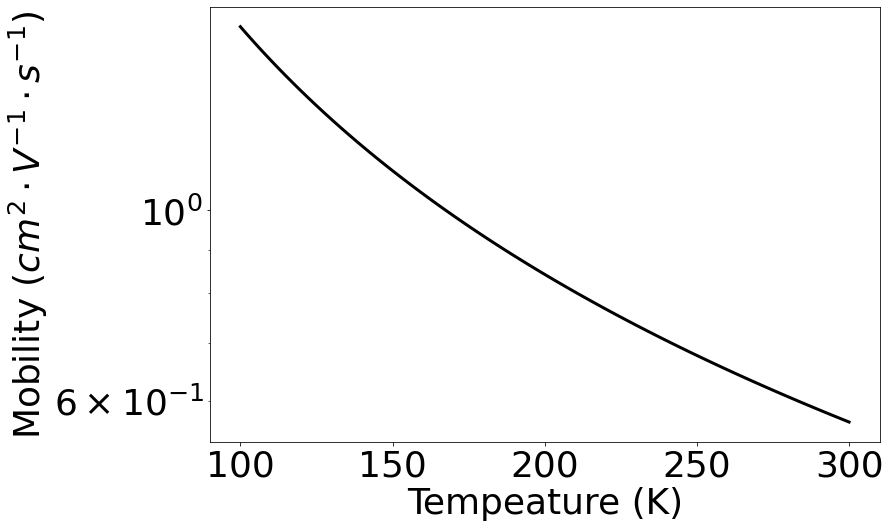

In [53]:
# Some constants
eSI = 1.60217663 * 1e-19
heV = 4.135667696*1e-15 #in eV * s 
hSI = 6.62607015*1e-34 #in J * s 
kb = 8.617333262*1e-5 # in eV

# The energy of the phonon mode that assists the polaron hopping
# Usually taken as the LO mode near zone center 
nu = 75 # in meV

# The distance between two hopping sites
R = 2.87012 * 1e-10 # in meter

# Hopping barrier
hopping = E_barrier

# The number of sites accepting the hopping along a specific direction
neighbor = 1

# The EHAM calculations
temperature = np.linspace(100, 300, 100, endpoint=True)
ket = (nu / 1000 / heV) * np.exp(-hopping / kb / temperature / 1000)
D = R * R * neighbor * ket
mu = eSI * D / (kb * temperature * eSI) * 1e4 # in cm^2 * V^-1 * s^-1


fig2 = plt.figure(2, figsize=(12,8))
plt.plot(temperature, mu, color='black', linewidth=3.0)
plt.xlabel('Tempeature (K)')
plt.ylabel(r'Mobility ($cm^2 \cdot V^{-1} \cdot s^{-1})$')
plt.yscale('log')